# Reasearch Vocoders

In [1]:
!pip install librosa --upgrade
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import IPython.display as ipd
import copy
import time

!gdown https://drive.google.com/uc?id=110yz4UGIbveLW8ENFI1DjypNXs96q0FZ

y, sr = librosa.load('/content/ex.wav',sr=16000) #Читаем файл
ipd.Audio(y, rate=sr) 

Requirement already up-to-date: librosa in /usr/local/lib/python3.7/dist-packages (0.8.1)
Downloading...
From: https://drive.google.com/uc?id=110yz4UGIbveLW8ENFI1DjypNXs96q0FZ
To: /content/ex.wav
100% 317k/317k [00:00<00:00, 2.78MB/s]


## Creation of Hparams class

In [2]:
class Hparams():
  def __init__(self, sr):
    self.n_fft = int(sr * 25 / 1000)
    self.hop_length=int(sr * 10 / 1000)
    self.n_mels = 40
    self.n_iter = 10
    self.win_length = 20

## Get Spectr

In [3]:
hp = Hparams(sr)
# Spectr
spectr = librosa.stft(y=y,hop_length=hp.hop_length,n_fft=hp.n_fft)
# Amplitude
ampl = np.abs(spectr) 
# Phase
phasa = np.angle(spectr)
# Signal with amplitude
y_ampl = librosa.istft(ampl,hop_length=hp.hop_length)
ipd.Audio(y_ampl, rate=sr) 

We can see, that the sound, restored only by the amplitude, is very poor quality

### Return the phase

In [4]:
# Add phase
ampl_phasa =  ampl*np.cos(phasa) + 1j*ampl*np.sin(phasa)
# Signal with amplitude and phase
y_ampl_phasa = librosa.istft(ampl_phasa,hop_length=hp.hop_length)
ipd.Audio(y_ampl_phasa, rate=sr)

The sound is very good

## Get Melspectrogram

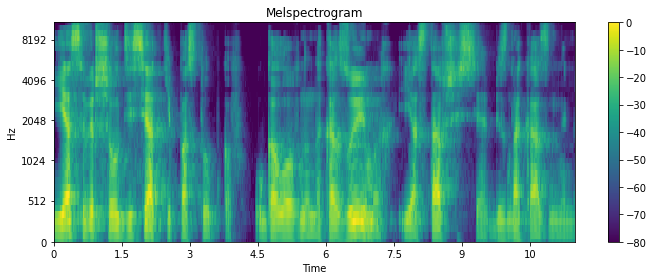

In [5]:
melspectr = librosa.feature.melspectrogram( 
    y,
    sr,
    n_fft=hp.n_fft,
    hop_length=hp.hop_length,
    n_mels=hp.n_mels
)

# For showing
S_dB = librosa.power_to_db(melspectr, ref=np.max)
plt.figure(figsize=(10, 4))
cmap = cm.get_cmap('viridis')
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', cmap=cmap)
plt.colorbar()
plt.title('Melspectrogram')
plt.tight_layout()
plt.show()

### Return melspectrogram to audio

In [6]:
ampl_mel = librosa.feature.inverse.mel_to_stft(melspectr, sr, n_fft=hp.n_fft)
y_mel_ampl = librosa.istft(ampl_mel,hop_length=hp.hop_length)
ipd.Audio(y_mel_ampl, rate=sr) 

The sound is expectedly bad

## Use Griffin-Lim

In [8]:
y_griffinlim = librosa.griffinlim(ampl_mel, hop_length=hp.hop_length)
ipd.Audio(y_griffinlim, rate=sr) 


### Return to Mel-phase

In [12]:
ampl_phasa =  ampl_mel*np.cos(phasa) + 1j*ampl_mel*np.sin(phasa)
y_mel_ampl_phasa = librosa.istft(ampl_phasa,hop_length=hp.hop_length)
ipd.Audio(y_mel_ampl_phasa, rate=sr) 

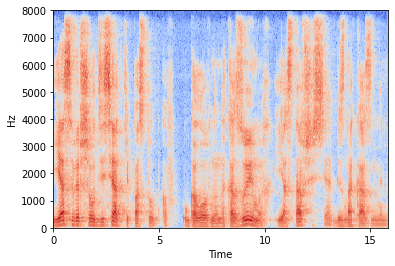

In [13]:
Xdb = 10.0 * np.log10(ampl**2 + 1e-10)
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

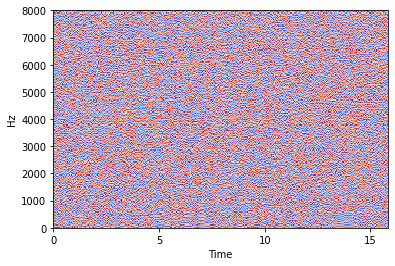

In [14]:
librosa.display.specshow(phasa, sr=sr, x_axis='time', y_axis='hz')

## Show all graphics

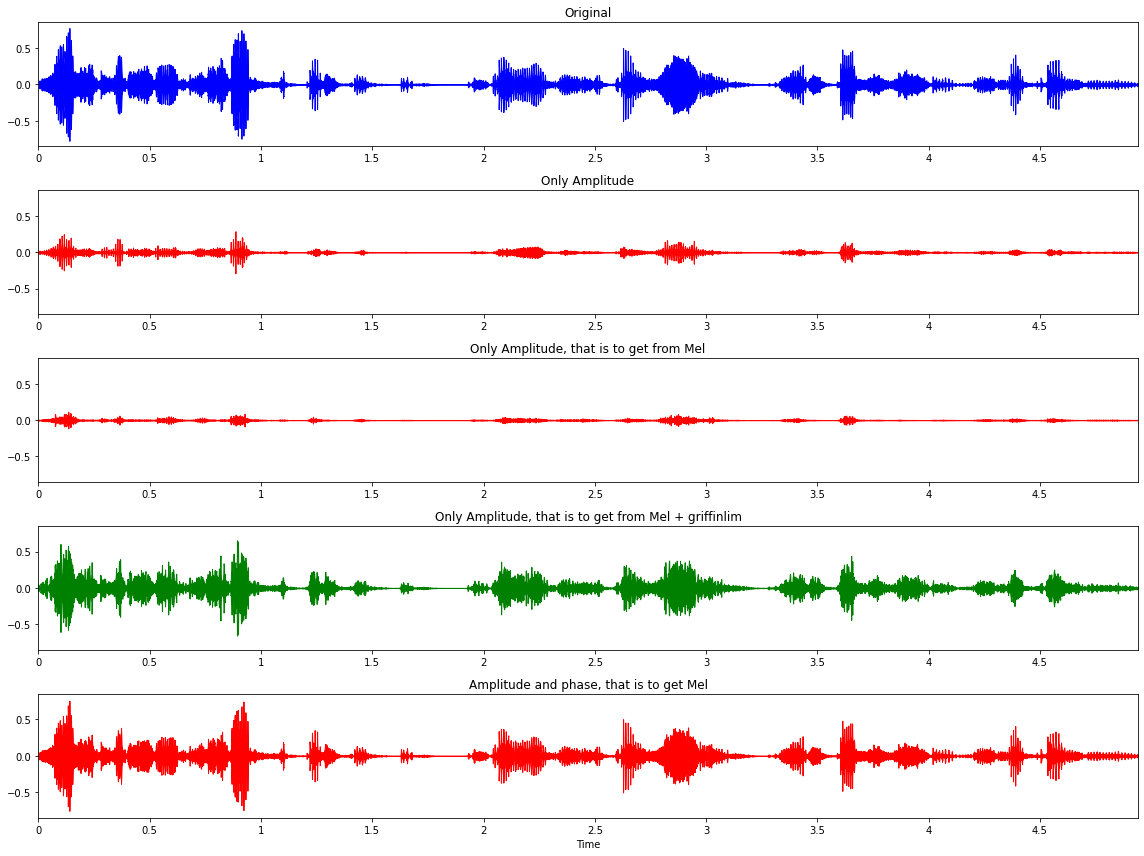

In [15]:
plt.figure(figsize=(16, 12))
ax = plt.subplot(5,1,1)
librosa.display.waveplot(y, sr=sr, color='b')
plt.title('Original')
plt.xlabel('')
plt.subplot(5,1,2, sharex=ax, sharey=ax)
librosa.display.waveplot(y_ampl, sr=sr, color='r')
plt.title('Only Amplitude')
plt.xlabel('')
plt.subplot(5,1,3, sharex=ax, sharey=ax)
librosa.display.waveplot(y_mel_ampl, sr=sr, color='r')
plt.title('Only Amplitude, that is to get from Mel')
plt.xlabel('')
plt.subplot(5,1,4, sharex=ax, sharey=ax)
librosa.display.waveplot(y_griffinlim, sr=sr, color='g')
plt.title('Only Amplitude, that is to get from Mel + griffinlim')
plt.xlabel('')
plt.subplot(5,1,5, sharex=ax, sharey=ax)
librosa.display.waveplot(y_mel_ampl_phasa, sr=sr, color='r')
plt.title('Amplitude and phase, that is to get Mel')
plt.tight_layout()
plt.show()

## Сonclusions

Although the main information is contained in the amplitude, it is impossible to recover a quality signal without phase information. You can try to use the Griffin-Lim algorithm, but it does not give a high-quality signal either.

By its nature, the amplitude spectrum contains many characteristic regions that the network can learn and reconstruct. The phase spectrum, on the other hand, is very random and difficult to reconstruct.

That is why the existing algorithms first obtain a spectrum, and only then receive a signal from it, without phase prediction.

## MelGan

The existing models are mainly autoregressive, which means that the chunks of sound are generated sequentially, which means that the speed of their operation is not very high.

The authors of the article decided to use the GAN network, which until then was usually used for working with pictures, to convert the melspectrum into raw sound.

The architecture consists of a MelGAN generator, 4 transposed convolutions and 3 * 4 Residual blocks. And also three discriminators, each of which contains 4 lowering convolutions. The second and third discriminators receive the signal compressed by 2 and 4 times, respectively, which allows more attention to the lower frequencies.

In [18]:
!git clone https://github.com/vlomme/MelGan-WavGan.git

Cloning into 'MelGan-WavGan'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 53 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [19]:
cd MelGan-WavGan/

/content/MelGan-WavGan


In [20]:
!gdown https://drive.google.com/uc?id=10tLduS5fGNWby7IKvfltuIfUWUeAp9SM
!unzip logs.zip

Downloading...
From: https://drive.google.com/uc?id=10tLduS5fGNWby7IKvfltuIfUWUeAp9SM
To: /content/MelGan-WavGan/logs.zip
653MB [00:20, 31.4MB/s]
Archive:  logs.zip
   creating: logs/
  inflating: logs/again_40k.pth      
  inflating: logs/mel_ckpt_51k.pt    
  inflating: logs/wav_ckpt_27k.pt    
  inflating: gen/000000_RUSLAN.mel   
  inflating: gen/000001_RUSLAN.mel   
  inflating: gen/nada.wav            
  inflating: gen/o1.wav              
  inflating: gen/o2.wav              
   creating: gen/orig/
  inflating: gen/orig/000000_RUSLAN.wav  
  inflating: gen/orig/000001_RUSLAN.wav  
  inflating: gen/orig/RUSLAN.wav     
  inflating: gen/RUSLAN.wav          
  inflating: gen/wav-batch_0_sentence_0-mel.wav  


## Synthesize from mel-spectrogramm

In [21]:
!python melgan.py -r g -f mel

Чекпоинт загружен: Эпоха 298, Шаг 518000
100% 2/2 [00:01<00:00,  1.81it/s]


### Original voice

In [22]:
y_orig, sr = librosa.load('./gen/orig/000000_RUSLAN.wav',sr=16000)
ipd.Audio(y_orig, rate=sr) 

### MelGAN vocoder

In [23]:
y_melgan, sr = librosa.load('./gen/output/mel_000000_RUSLAN.wav',sr=16000)
ipd.Audio(y_melgan, rate=sr) 

## Sythesize with Griffin-Lim

In [24]:
!python melgan.py -r g -f wav

Чекпоинт загружен: Эпоха 298, Шаг 518000
100% 5/5 [00:03<00:00,  1.57it/s]


### Original voice

In [25]:
y_orig, sr = librosa.load('./gen/orig/RUSLAN.wav',sr=16000)
ipd.Audio(y_orig, rate=sr) 

### Griffin-Lim Algorithm

In [26]:
y_griffinlim, sr = librosa.load('./gen/RUSLAN.wav',sr=16000)
ipd.Audio(y_griffinlim, rate=sr) 

### MelGan vocoder

In [27]:
y_melgan, sr = librosa.load('./gen/output/mel_RUSLAN.wav',sr=16000)
ipd.Audio(y_melgan, rate=sr) 

## Conclusion 

My experiments have shown that the model gives good quality, slightly worse than WaveRNN, but works much faster. To improve the quality, you either need to train the model for much longer, or try other approaches.

From the shortcomings, it can be noted that the model requires a melspectrogram in the format in which it was trained, which requires coordination and retraining for specific synthesizer models.

## WavGan

Idea. Why synthesize from a melspectrogram, if you can use Griffin-Lim and get a signal that is very similar to the original sound and you just need to correct it. This approach led to the development of WavGan. Its generator structure is similar to U-net, and the discriminator is taken from MelGAN. Such a model learns much faster, does not require tuning for various synthesizers, can potentially remove noise and gives a quality similar to MelGAN.

### Sythesize from mel-spectrogramm

In [28]:
!python wavgan.py -r g -f mel

Чекпоинт загружен: Эпоха 108, Шаг 277000
100% 2/2 [00:01<00:00,  1.62it/s]


In [29]:
y_wavgan, sr = librosa.load('./gen/output/wav_000000_RUSLAN.wav',sr=16000)
ipd.Audio(y_wavgan, rate=sr) 

### Griffin-Lim Algorithm

In [30]:
!python wavgan.py -r g -f wav

Чекпоинт загружен: Эпоха 108, Шаг 277000
100% 5/5 [00:03<00:00,  1.35it/s]


In [31]:
y_wavgan, sr = librosa.load('./gen/output/wav_RUSLAN.wav',sr=16000)
ipd.Audio(y_wavgan, rate=sr) 

## WavGan with TTS

In [32]:
%tensorflow_version 2.x
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0
!sudo apt-get install portaudio19-dev
!pip install PyAudio
!pip install sounddevice
!pip install unidecode

!gdown https://drive.google.com/uc?id=19Gl9ejMUm_ll6cKozt5N99qDBN25FXDA
!unzip test.zip

Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 377.1MB 32kB/s 
     |████████████████████████████████| 3.2MB 36.4MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 491kB 47.7MB/s 
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 184 kB of archive

In [33]:
cd test/

/content/MelGan-WavGan/test


In [36]:
!python synthesize.py --text_list 'Здравствуй юность в сопогах' --checkpoint male

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
!python wavgan.py -r g -f wav

In [ ]:
y_tac, sr = librosa.load('./tacotron_output/output/wav_wav-batch_0_sentence_0-mel.wav',sr=16000)
ipd.Audio(y_tac, rate=sr) 